# Reinforcement Learning hyperparameter tuning with hyperoptax and rejax

In [1]:
import time

import jax
import rejax
import matplotlib.pyplot as plt

from hyperoptax.grid_search import RandomSearch
from hyperoptax.spaces import LogSpace, LinearSpace

rng = jax.random.PRNGKey(42)

In [2]:
# make an RL agent
ppo = rejax.algos.PPO
jit_train = jax.jit(ppo.train)
agent = ppo.create(env="CartPole-v1")
ts, evaluation = jit_train(agent, rng)

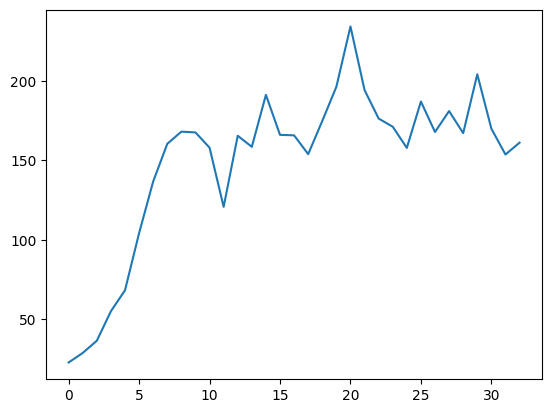

In [3]:
plt.plot(evaluation[1].mean(axis=1));

In [4]:
# Optimise RL hyperparameters

hparams = {
    "learning_rate": LogSpace(1e-5, 1e-1, 10),
    "max_grad_norm": LinearSpace(0.01, 10, 10),
    "ent_coef": LogSpace(1e-4, 1e1, 10),
}


def wrapper(learning_rate, max_grad_norm, ent_coef):
    agent = ppo.create(
        env="CartPole-v1",
        learning_rate=learning_rate,
        max_grad_norm=max_grad_norm,
        ent_coef=ent_coef,
    )
    ts, evaluation = jit_train(agent, rng)
    return evaluation[1].mean(axis=1)[-1]


search = RandomSearch(hparams, wrapper)

start = time.time()
result = search.optimise(100, n_parallel=50).flatten()

print(f"Time taken: {time.time() - start:.2f} seconds")
print(
    "Best hyperparameters:\n"
    f"Learning rate: {result.tolist()[0]:4f}\n"
    f"Max grad norm: {result.tolist()[1]:4f}\n"
    f"Ent coef: {result.tolist()[2]:4f}"
)

Time taken: 144.81 seconds
Best hyperparameters:
Learning rate: 0.001668
Max grad norm: 10.000000
Ent coef: 0.001292


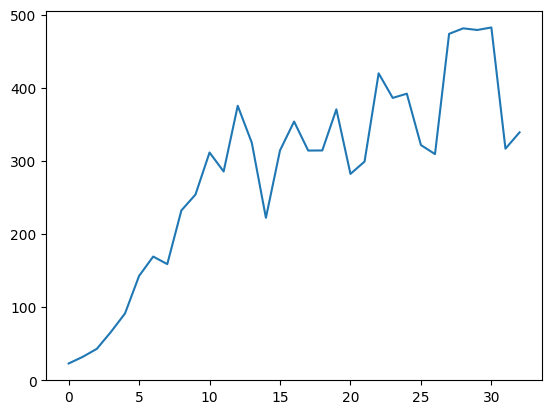

In [7]:
# Train and evaluate the tuned RL agent
agent = ppo.create(
    env="CartPole-v1",
    learning_rate=result[0],
    max_grad_norm=result[1],
    ent_coef=result[2],
)
ts, evaluation = jit_train(agent, rng)

plt.plot(evaluation[1].mean(axis=1));